# EGG Signal Processing with GastroPy

This tutorial walks you through a complete electrogastrography (EGG) analysis
pipeline using GastroPy. We use real EGG data from Wolpert et al. (2020), a
large normative study that established standardized analysis procedures for EGG
in psychophysiological research.

**What you will learn:**
- What EGG is and what the gastric rhythm looks like
- How to load and inspect multi-channel EGG data
- How to compute power spectral density and select the best channel
- How to bandpass filter, extract instantaneous phase, and detect cycles
- How to detect artifacts and compute quality metrics
- How to use the `egg_process` convenience function for rapid analysis

**Prerequisites:** Basic Python and NumPy. No prior EGG experience needed.

**Reference:**
Wolpert, N., Rebollo, I., & Tallon-Baudry, C. (2020). Electrogastrography for
psychophysiological research: Practical considerations, analysis pipeline, and
normative data in a large sample. *Psychophysiology*, 57, e13599.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gastropy as gp

# Display settings
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

## 1. Background: What is Electrogastrography?

Electrogastrography (EGG) is a non-invasive technique for recording the
electrical activity of the stomach from electrodes placed on the abdominal
surface. The stomach generates a slow electrical oscillation called the
**gastric slow wave**, driven by interstitial cells of Cajal (ICC) in the
corpus and antrum.

### The Gastric Rhythm

The normal gastric slow wave oscillates at approximately **3 cycles per minute
(cpm)**, or equivalently **0.05 Hz**, with a period of about **20 seconds**.
This is called **normogastria**. Deviations from this rhythm are classified as:

| Rhythm           | Rate (cpm) | Frequency (Hz)   | Period (s) |
|------------------|-----------|-------------------|------------|
| **Bradygastria** | 1–2       | 0.017–0.033        | 30–60      |
| **Normogastria** | 2–4       | 0.033–0.067        | 15–30      |
| **Tachygastria** | 4–10      | 0.067–0.167        | 6–15       |

A high-quality EGG recording will show a clear spectral peak in the
normogastric range, with the majority of detected cycles having durations
between 15 and 30 seconds.

### Electrode Placement

Wolpert et al. (2020) used a 7-electrode bipolar montage placed on the
abdomen. One electrode pair sits roughly over the gastric antrum; others
capture the spatial spread of the slow wave. Because signal quality varies
across electrodes, we typically select the **best channel** — the one
with the strongest normogastric peak — for further analysis.

## 2. Loading and Inspecting the Data

GastroPy ships with bundled sample datasets so you can start immediately.
We will use `load_egg()`, which returns a 7-channel recording from the
Wolpert et al. (2020) normative dataset, already downsampled to 10 Hz.

In [2]:
# Load the Wolpert sample EGG recording
egg = gp.load_egg()

# Inspect the returned dictionary
print(f"Keys: {list(egg.keys())}")
print(f"Signal shape: {egg['signal'].shape}  (channels x samples)")
print(f"Sampling rate: {egg['sfreq']} Hz")
print(f"Channel names: {list(egg['ch_names'])}")
print(f"Duration: {egg['duration_s']:.0f} seconds ({egg['duration_s']/60:.1f} minutes)")
print(f"Source: {egg['source']}")

Keys: ['signal', 'sfreq', 'ch_names', 'duration_s', 'source']
Signal shape: (7, 7580)  (channels x samples)
Sampling rate: 10.0 Hz
Channel names: [np.str_('EGG1'), np.str_('EGG2'), np.str_('EGG3'), np.str_('EGG4'), np.str_('EGG5'), np.str_('EGG6'), np.str_('EGG7')]
Duration: 758 seconds (12.6 minutes)
Source: wolpert_2020


In [3]:
# Unpack for convenience
signal = egg["signal"]       # shape (7, n_samples)
sfreq = egg["sfreq"]         # 10.0 Hz
ch_names = list(egg["ch_names"])
n_channels, n_samples = signal.shape

# Create a time vector
times = np.arange(n_samples) / sfreq
print(f"{n_channels} channels, {n_samples} samples, {times[-1]:.1f} s total")

7 channels, 7580 samples, 757.9 s total


### Raw Signal Overview

Let's plot the raw EGG from all 7 channels. EGG signals are very slow
(~0.05 Hz) and may have DC offsets or drift, so we mean-center each channel
for display.

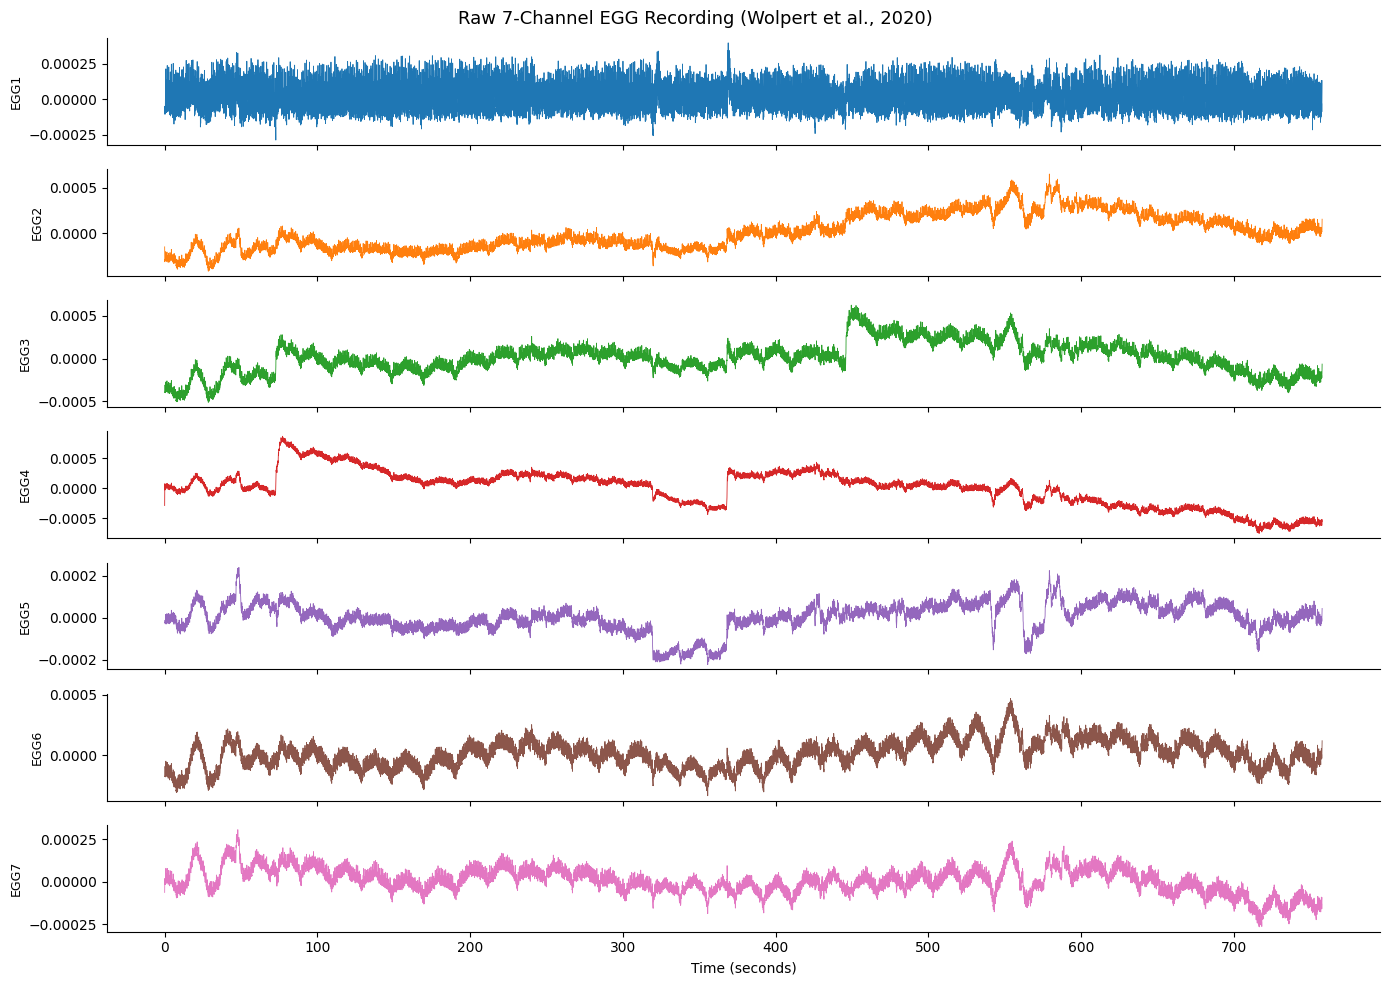

In [4]:
fig, axes = plt.subplots(n_channels, 1, figsize=(14, 10), sharex=True)
for i, ax in enumerate(axes):
    centered = signal[i] - np.mean(signal[i])
    ax.plot(times, centered, linewidth=0.6, color=f"C{i}")
    ax.set_ylabel(ch_names[i], fontsize=9)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
axes[-1].set_xlabel("Time (seconds)")
fig.suptitle("Raw 7-Channel EGG Recording (Wolpert et al., 2020)", fontsize=13)
fig.tight_layout()
plt.show()

## 3. Spectral Analysis and Channel Selection

The first step in any EGG analysis is to compute the **power spectral density
(PSD)** and identify which channel has the strongest gastric rhythm. GastroPy's
`psd_welch` uses 200-second Hann windows with zero-padding to 1000 seconds,
giving fine frequency resolution in the sub-0.1 Hz range where the gastric
signal lives.

### Why These PSD Parameters?

EGG frequencies are extremely low (0.03–0.07 Hz). Standard PSD parameters
designed for EEG or EMG would give far too coarse a resolution here. The
convention from Wolpert et al. (2020) is:

- **Window length**: 200 seconds (captures ~10 gastric cycles per window)
- **Overlap**: 75% (smooth estimates for short recordings)
- **Zero-padding**: to 1000 seconds (gives ~0.001 Hz frequency resolution)

These parameters are built into GastroPy's `psd_welch` function.

In [5]:
# Compute PSD for every channel (using Wolpert overlap convention)
all_psd = []
for ch_idx in range(n_channels):
    freqs, psd = gp.psd_welch(signal[ch_idx], sfreq, fmin=0.0, fmax=0.1, overlap=0.75)
    all_psd.append(psd)

# Stack into a (n_channels, n_freqs) array for plotting
psd_matrix = np.array(all_psd)

print(f"PSD shape: {psd_matrix.shape}")
print(f"Frequency range: {freqs[0]:.4f} - {freqs[-1]:.4f} Hz")
print(f"Frequency resolution: {freqs[1] - freqs[0]:.4f} Hz")

PSD shape: (7, 101)
Frequency range: 0.0000 - 0.1000 Hz
Frequency resolution: 0.0010 Hz


In [6]:
# Automatic best-channel selection
best_idx, peak_freq, best_freqs, best_psd = gp.select_best_channel(signal, sfreq)

print(f"Best channel: {ch_names[best_idx]} (index {best_idx})")
print(f"Peak frequency: {peak_freq:.4f} Hz ({peak_freq * 60:.2f} cpm)")
print(f"Peak period: {1/peak_freq:.1f} seconds")

Best channel: EGG6 (index 5)
Peak frequency: 0.0530 Hz (3.18 cpm)
Peak period: 18.9 seconds


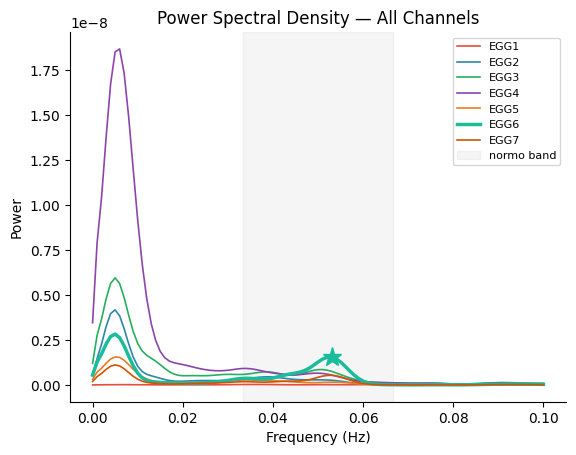

In [7]:
# Plot PSD for all channels, highlighting the best one
fig, ax = gp.plot_psd(
    freqs, psd_matrix,
    ch_names=ch_names,
    best_idx=best_idx,
    peak_freq=peak_freq,
)
ax.set_title("Power Spectral Density — All Channels")
plt.show()

### Interpreting the PSD

A few things to notice:

1. **Clear normogastric peak**: The best channel shows a sharp peak within
   the shaded normogastric band (2–4 cpm / 0.033–0.067 Hz). This is the
   hallmark of a high-quality EGG recording.
2. **Channel variability**: Some channels show a weak or absent peak — this
   is normal and is why channel selection matters.
3. **Low-frequency power**: There is often substantial power below 0.02 Hz
   from respiratory and movement artifacts. The bandpass filter (next section)
   will remove this.

The peak frequency tells us this participant's dominant gastric rhythm. A peak
near 0.05 Hz (3 cpm, 20-second period) is typical for a healthy adult.

## 4. Step-by-Step Processing Pipeline

Now we will process the best channel through the standard EGG analysis pipeline,
calling each GastroPy function individually. This gives you full control and
understanding of each step. Later (Section 7), we will show how `egg_process`
does all of this in one call.

We follow the Wolpert et al. (2020) pipeline:
1. Bandpass filter to the normogastric band
2. Hilbert transform to get instantaneous phase and amplitude
3. Detect individual gastric cycles
4. Detect phase-based artifacts
5. Compute summary metrics

In [8]:
# Extract the best channel for processing
best_signal = signal[best_idx]
print(f"Processing channel: {ch_names[best_idx]}")
print(f"Signal shape: {best_signal.shape}")
print(f"Signal range: [{best_signal.min():.6f}, {best_signal.max():.6f}]")

Processing channel: EGG6
Signal shape: (7580,)
Signal range: [-0.004542, -0.003734]


### Step 1: Bandpass Filtering

We filter the signal to isolate the normogastric band (0.033–0.067 Hz).
GastroPy uses a zero-phase FIR bandpass filter with adaptive tap count,
applied via `filtfilt` to avoid phase distortion.

The built-in frequency band constants make it easy to refer to standard
gastric bands:

In [9]:
# GastroPy provides named frequency band constants
print(f"Normogastria: {gp.NORMOGASTRIA.f_lo:.4f}-{gp.NORMOGASTRIA.f_hi:.4f} Hz "
      f"({gp.NORMOGASTRIA.cpm_lo:.1f}-{gp.NORMOGASTRIA.cpm_hi:.1f} cpm)")
print(f"Bradygastria: {gp.BRADYGASTRIA.f_lo:.4f}-{gp.BRADYGASTRIA.f_hi:.4f} Hz "
      f"({gp.BRADYGASTRIA.cpm_lo:.1f}-{gp.BRADYGASTRIA.cpm_hi:.1f} cpm)")
print(f"Tachygastria: {gp.TACHYGASTRIA.f_lo:.4f}-{gp.TACHYGASTRIA.f_hi:.4f} Hz "
      f"({gp.TACHYGASTRIA.cpm_lo:.1f}-{gp.TACHYGASTRIA.cpm_hi:.1f} cpm)")

Normogastria: 0.0333-0.0667 Hz (2.0-4.0 cpm)
Bradygastria: 0.0200-0.0300 Hz (1.2-1.8 cpm)
Tachygastria: 0.0700-0.1700 Hz (4.2-10.2 cpm)


In [10]:
# Apply normogastric bandpass filter
filtered, filt_info = gp.apply_bandpass(
    best_signal, sfreq,
    low_hz=gp.NORMOGASTRIA.f_lo,
    high_hz=gp.NORMOGASTRIA.f_hi,
)

print(f"Filter method: {filt_info['filter_method']}")
print(f"FIR taps: {filt_info['fir_numtaps']}")
print(f"Filtered signal shape: {filtered.shape}")

Filter method: fir
FIR taps: 501
Filtered signal shape: (7580,)


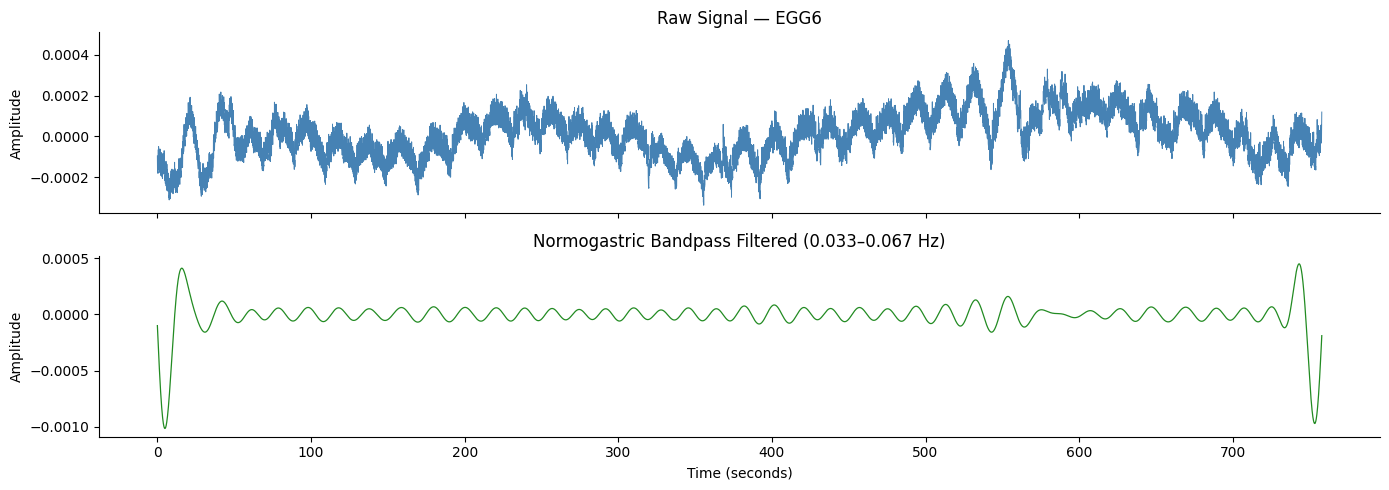

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 5), sharex=True)

ax1.plot(times, best_signal - np.mean(best_signal), linewidth=0.7, color="steelblue")
ax1.set_ylabel("Amplitude")
ax1.set_title(f"Raw Signal — {ch_names[best_idx]}")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax2.plot(times, filtered, linewidth=0.9, color="forestgreen")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Time (seconds)")
ax2.set_title("Normogastric Bandpass Filtered (0.033–0.067 Hz)")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

fig.tight_layout()
plt.show()

### Step 2: Hilbert Transform — Phase and Amplitude

The **Hilbert transform** converts our filtered signal into a complex
**analytic signal**, from which we extract:

- **Instantaneous phase** (radians, -π to +π): tells us *where* we are
  within each gastric cycle at every moment in time
- **Instantaneous amplitude** (envelope): reflects the *strength* of the
  gastric rhythm over time

Phase is the key quantity for gastric-brain coupling analyses: it lets us
assign every time point (or fMRI volume) to a specific phase of the
stomach's contraction cycle.

In [12]:
# Hilbert transform -> phase and amplitude
phase, analytic = gp.instantaneous_phase(filtered)
amplitude = np.abs(analytic)

print(f"Phase range: [{phase.min():.2f}, {phase.max():.2f}] radians")
print(f"Amplitude range: [{amplitude.min():.6f}, {amplitude.max():.6f}]")

Phase range: [-3.14, 3.14] radians
Amplitude range: [0.000001, 0.001092]


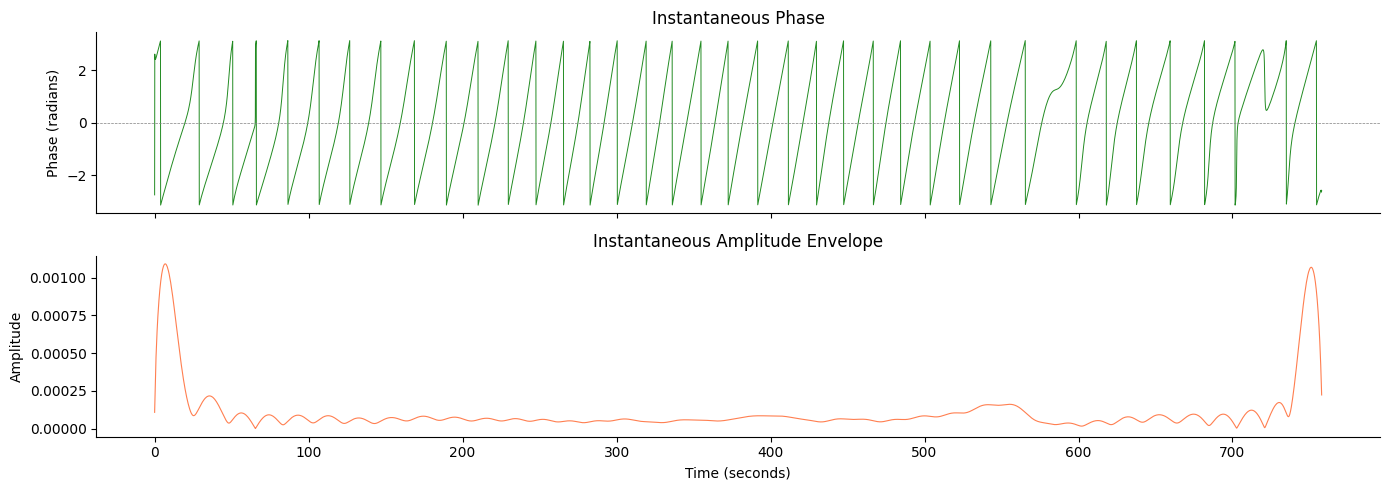

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 5), sharex=True)

# Phase (sawtooth pattern)
ax1.plot(times, phase, linewidth=0.7, color="forestgreen")
ax1.set_ylabel("Phase (radians)")
ax1.set_title("Instantaneous Phase")
ax1.axhline(0, color="grey", linewidth=0.5, linestyle="--")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# Amplitude envelope
ax2.plot(times, amplitude, linewidth=0.8, color="coral")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Time (seconds)")
ax2.set_title("Instantaneous Amplitude Envelope")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

fig.tight_layout()
plt.show()

### Step 3: Cycle Detection

GastroPy detects individual gastric cycles by tracking when the unwrapped
phase crosses each 2π boundary. This gives us a list of cycle durations
in seconds. For a normogastric signal, most cycles should be 15–30 seconds
long (corresponding to 2–4 cpm).

In [14]:
# Detect complete gastric cycles
durations = gp.cycle_durations(phase, times)

print(f"Number of cycles detected: {len(durations)}")
print(f"Mean cycle duration: {np.mean(durations):.1f} s")
print(f"Std cycle duration:  {np.std(durations, ddof=1):.1f} s")
print(f"Range: [{np.min(durations):.1f}, {np.max(durations):.1f}] s")
print(f"\nExpected period for 3 cpm: {60/3:.1f} s")

Number of cycles detected: 37
Mean cycle duration: 20.3 s
Std cycle duration:  3.6 s
Range: [15.9, 33.2] s

Expected period for 3 cpm: 20.0 s


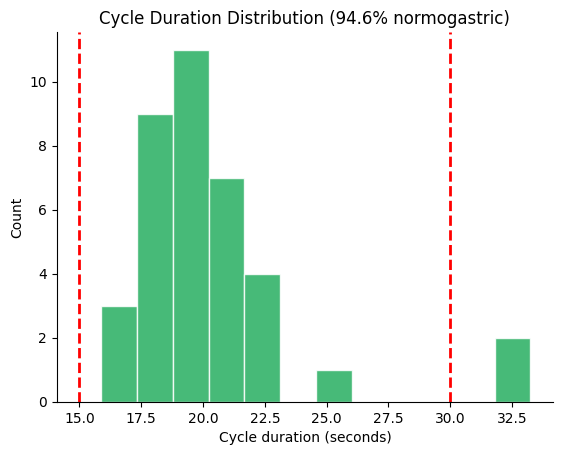

In [15]:
# Cycle duration histogram with normogastric boundaries
fig, ax = gp.plot_cycle_histogram(durations)
plt.show()

### Step 4: Artifact Detection

Wolpert et al. (2020) defined two phase-based criteria for detecting
artifact cycles:

1. **Non-monotonic phase**: Within each cycle, the phase should increase
   monotonically from -π to +π. Cycles where this fails indicate
   distortions from motion, breathing, or electrode artifacts.
2. **Duration outliers**: Cycles whose duration falls more than 3 standard
   deviations from the mean are flagged.

Cycles flagged by either criterion are marked as artifacts.

In [16]:
# Detect phase-based artifacts
artifact_info = gp.detect_phase_artifacts(phase, times, sd_threshold=3.0)

print(f"Total cycles (from edges): {len(artifact_info['cycle_durations_s'])}")
print(f"Non-monotonic cycles: {len(artifact_info['nonmonotonic_cycles'])}")
print(f"Duration outlier cycles: {len(artifact_info['duration_outlier_cycles'])}")
print(f"Total artifact cycles: {artifact_info['n_artifacts']}")
print(f"Samples flagged: {artifact_info['artifact_mask'].sum()} / {n_samples}")

Total cycles (from edges): 39
Non-monotonic cycles: 3
Duration outlier cycles: 2
Total artifact cycles: 3
Samples flagged: 406 / 7580


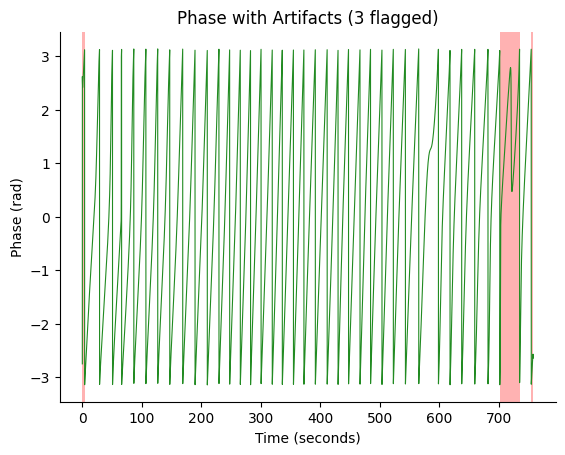

In [17]:
# Visualize artifacts on the phase time series
fig, ax = gp.plot_artifacts(phase, times, artifact_info)
plt.show()

## 5. Computing EGG Quality Metrics

Now we compute the standard metrics used to characterize EGG quality and
gastric rhythm stability. These metrics are commonly reported in the EGG
literature.

In [18]:
# --- Cycle Statistics ---
c_stats = gp.cycle_stats(durations)
print("Cycle Statistics:")
print(f"  N cycles:        {c_stats['n_cycles']}")
print(f"  Mean duration:   {c_stats['mean_cycle_dur_s']:.2f} s")
print(f"  SD duration:     {c_stats['sd_cycle_dur_s']:.2f} s")
print(f"  Within 3 SD:     {c_stats['prop_within_3sd']:.0%}")

# --- Proportion Normogastric ---
prop_normo = gp.proportion_normogastric(durations)
print(f"\nProportion normogastric: {prop_normo:.0%}")

# --- Instability Coefficient ---
ic = gp.instability_coefficient(durations)
print(f"Instability coefficient: {ic:.4f}")

# --- Band Power ---
bp = gp.band_power(freqs, psd_matrix[best_idx], gp.NORMOGASTRIA)
print(f"\nNormogastric band power:")
print(f"  Peak frequency:  {bp['peak_freq_hz']:.4f} Hz ({bp['peak_freq_hz']*60:.2f} cpm)")
print(f"  Max power:       {bp['max_power']:.6f}")
print(f"  Proportion:      {bp['prop_power']:.1%}")

Cycle Statistics:
  N cycles:        37
  Mean duration:   20.29 s
  SD duration:     3.57 s
  Within 3 SD:     95%

Proportion normogastric: 95%
Instability coefficient: 0.1759

Normogastric band power:
  Peak frequency:  0.0530 Hz (3.18 cpm)
  Max power:       0.000000
  Proportion:      77.9%


### Interpreting the Metrics

| Metric | What It Means | Good Value |
|--------|---------------|------------|
| **Proportion normogastric** | Fraction of cycles with 15–30 s duration | > 70% |
| **Instability coefficient** | SD(freq) / mean(freq) — lower is more stable | < 0.10 |
| **Cycle SD** | Variability in cycle duration | < 6 s |
| **Band power proportion** | % of total spectral power in normogastric band | Higher is better |

These thresholds are conventions from the EGG literature. GastroPy's
`assess_quality` function applies them automatically:

In [19]:
# Automated quality assessment
qc = gp.assess_quality(
    n_cycles=c_stats["n_cycles"],
    cycle_sd=c_stats["sd_cycle_dur_s"],
    prop_normo=prop_normo,
)

print("Quality Assessment:")
for key, val in qc.items():
    status = "PASS" if val else "FAIL"
    print(f"  {key:24s}: {status}")

Quality Assessment:
  sufficient_cycles       : PASS
  stable_rhythm           : PASS
  normogastric_dominant   : PASS
  overall                 : PASS


## 6. Multi-Band Time-Frequency Analysis

So far we filtered only to the normogastric band. In practice, researchers
often want to characterize activity across all three gastric bands
(bradygastria, normogastria, tachygastria) to understand the full spectral
profile of a recording.

GastroPy's `multiband_analysis` does this automatically: for each band, it
finds the peak frequency, applies a narrowband filter (peak ± 0.015 Hz),
extracts phase and amplitude, detects cycles, and computes metrics.

In [20]:
# Run per-band decomposition on the best channel
results = gp.multiband_analysis(best_signal, sfreq)

# Summarize results across bands
print(f"{'Band':<12} {'Peak (Hz)':<12} {'Peak (cpm)':<12} {'N cycles':<10} "
      f"{'IC':<10} {'Power %':<10}")
print("-" * 66)
for band_name, res in results.items():
    n_cyc = res["cycle_stats"]["n_cycles"]
    ic_val = res["instability_coefficient"]
    peak = res["peak_freq_hz"]
    prop = res["prop_power"]
    print(f"{band_name:<12} {peak:<12.4f} {peak*60:<12.2f} {n_cyc:<10} "
          f"{ic_val:<10.4f} {prop:<10.1%}")

Band         Peak (Hz)    Peak (cpm)   N cycles   IC         Power %   
------------------------------------------------------------------
brady        0.0300       1.80         10         1.0639     7.3%      
normo        0.0530       3.18         38         0.1470     76.0%     
tachy        0.0960       5.76         72         0.2275     6.9%      


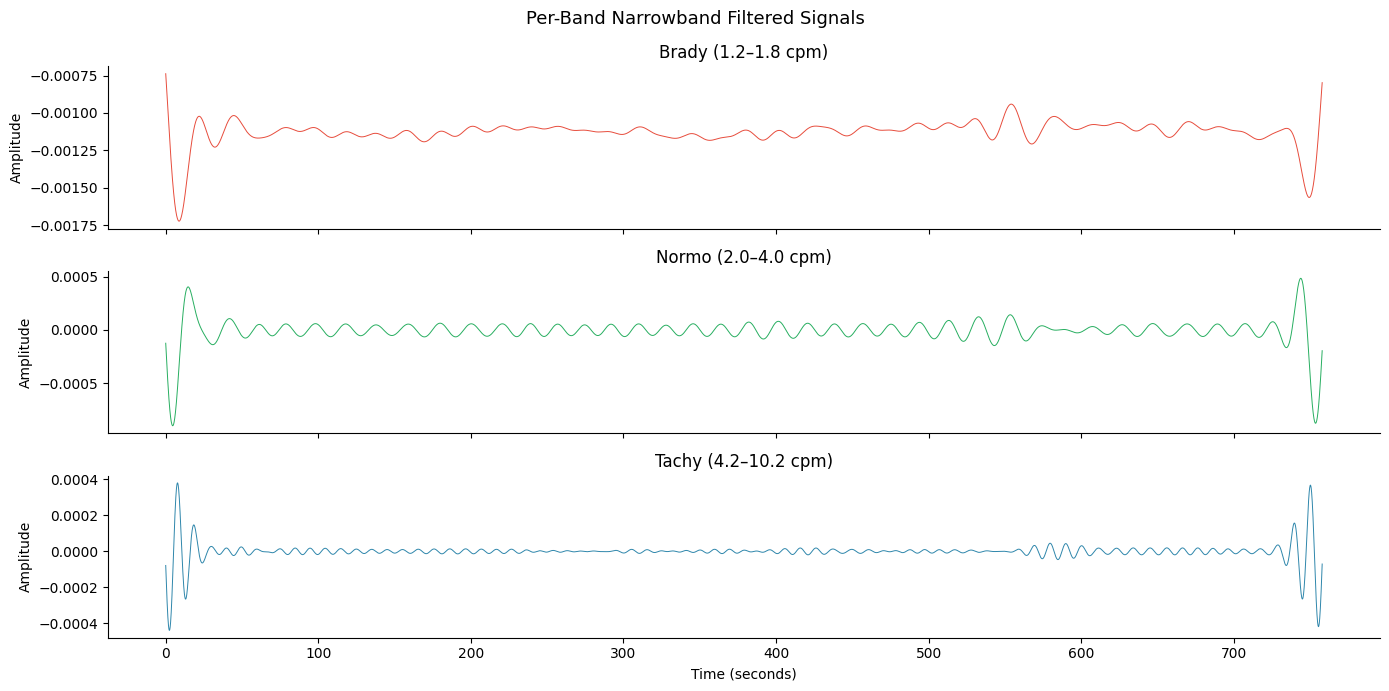

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)
band_colors = {"brady": "#E74C3C", "normo": "#27AE60", "tachy": "#2E86AB"}

for ax, (band_name, res) in zip(axes, results.items()):
    filt = res["filtered"]
    if not np.all(np.isnan(filt)):
        ax.plot(times, filt, linewidth=0.7, color=band_colors[band_name])
    band_info = res["band"]
    ax.set_title(f"{band_name.capitalize()} ({band_info['f_lo']*60:.1f}–{band_info['f_hi']*60:.1f} cpm)")
    ax.set_ylabel("Amplitude")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[-1].set_xlabel("Time (seconds)")
fig.suptitle("Per-Band Narrowband Filtered Signals", fontsize=13)
fig.tight_layout()
plt.show()

## 7. The `egg_process` Convenience Function

If you don't need fine-grained control over each step, `egg_process` runs
the entire pipeline — filtering, phase extraction, cycle detection, and metric
computation — in a single call. It returns:

- A **DataFrame** with columns `raw`, `filtered`, `phase`, `amplitude`
- An **info dict** containing all computed metrics

In [22]:
# Run the full pipeline in one call
signals_df, info = gp.egg_process(best_signal, sfreq)

print("DataFrame columns:", list(signals_df.columns))
print(f"DataFrame shape: {signals_df.shape}")
print()
print("Info keys:", list(info.keys()))

DataFrame columns: ['raw', 'filtered', 'phase', 'amplitude']
DataFrame shape: (7580, 4)

Info keys: ['sfreq', 'band', 'filter', 'peak_freq_hz', 'cycle_durations_s', 'cycle_stats', 'instability_coefficient', 'proportion_normogastric', 'band_power']


In [23]:
# All the key metrics in one place
print(f"Peak frequency:          {info['peak_freq_hz']:.4f} Hz ({info['peak_freq_hz']*60:.2f} cpm)")
print(f"Cycles detected:         {info['cycle_stats']['n_cycles']}")
print(f"Mean cycle duration:     {info['cycle_stats']['mean_cycle_dur_s']:.2f} s")
print(f"SD cycle duration:       {info['cycle_stats']['sd_cycle_dur_s']:.2f} s")
print(f"Instability coefficient: {info['instability_coefficient']:.4f}")
print(f"Proportion normogastric: {info['proportion_normogastric']:.0%}")
print(f"Band power proportion:   {info['band_power']['prop_power']:.1%}")

Peak frequency:          0.0530 Hz (3.18 cpm)
Cycles detected:         37
Mean cycle duration:     20.29 s
SD cycle duration:       3.57 s
Instability coefficient: 0.1759
Proportion normogastric: 95%
Band power proportion:   80.3%


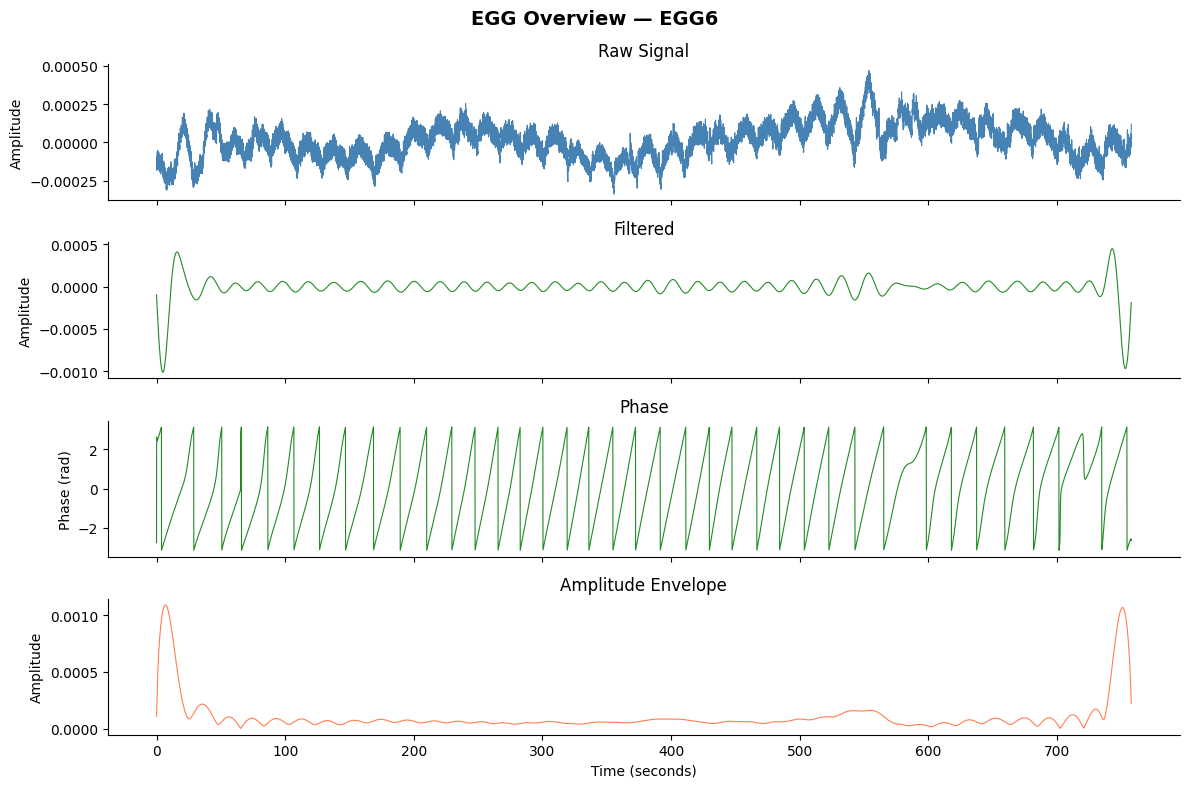

In [24]:
# 4-panel overview using the convenience plotting function
fig, axes = gp.plot_egg_overview(signals_df, sfreq, title=f"EGG Overview — {ch_names[best_idx]}")
plt.show()

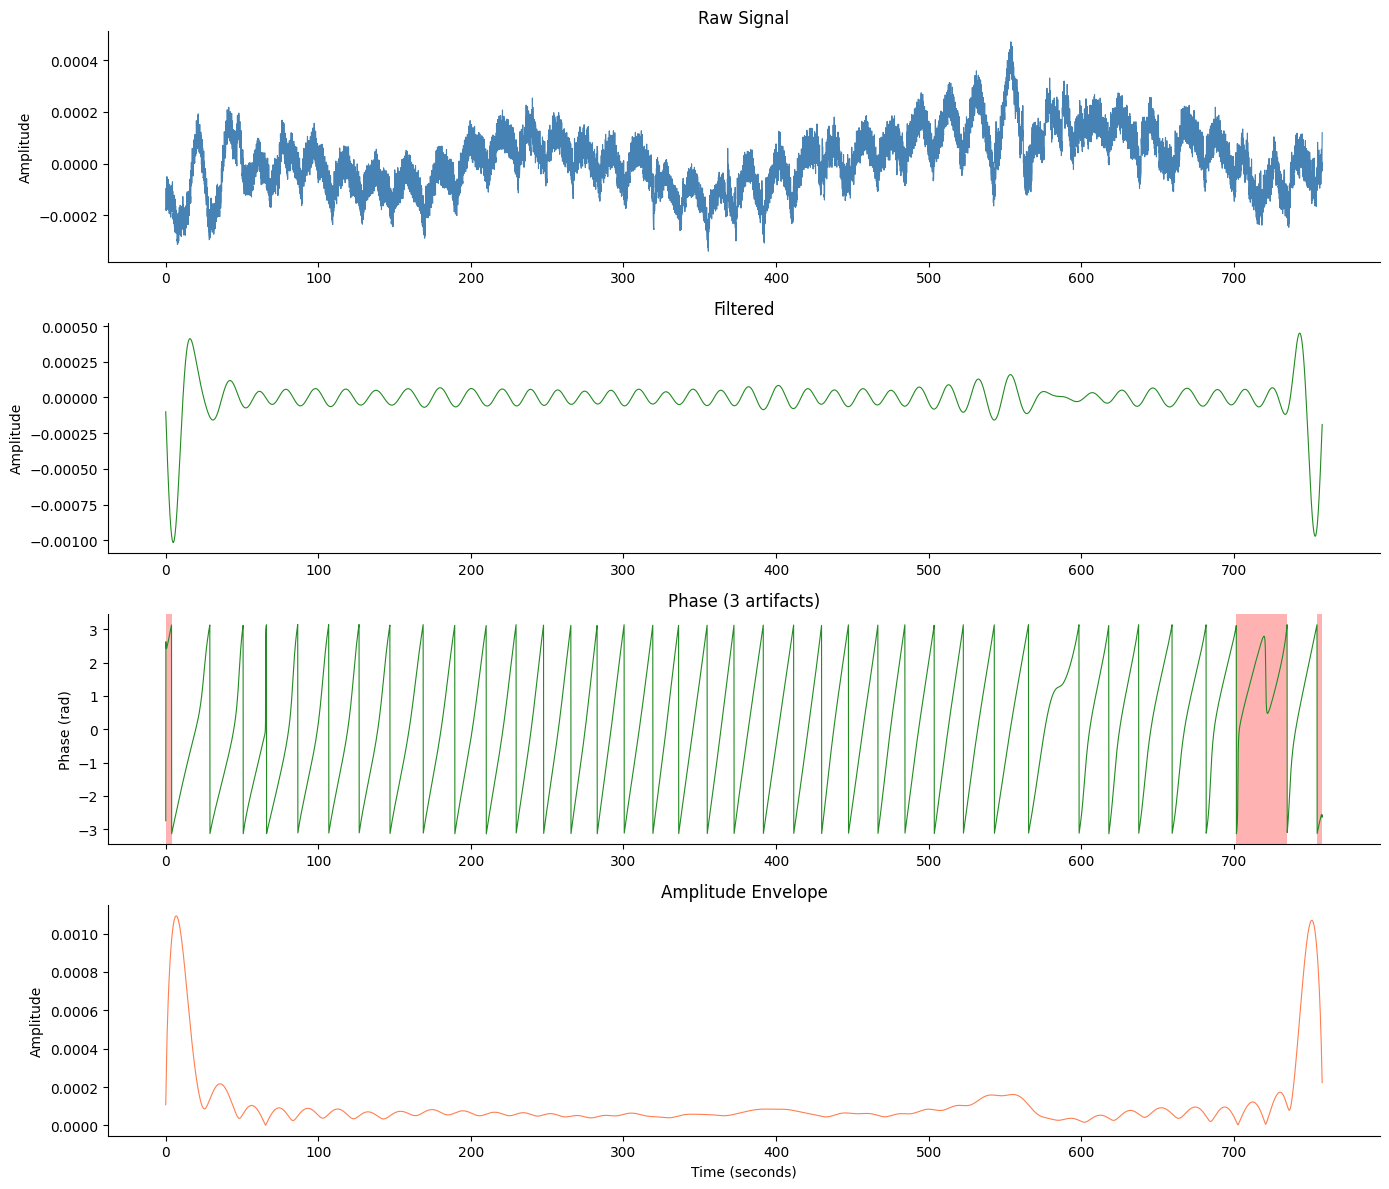

In [25]:
# Comprehensive figure with artifact overlay
fig, axes = gp.plot_egg_comprehensive(signals_df, sfreq, artifact_info=artifact_info)
plt.show()

## 8. Summary and Validation

Let's compile a final summary to validate our results against expected
values from the Wolpert et al. (2020) normative data (healthy adults, resting
EGG).

In [26]:
# Final summary
print("=" * 60)
print("  EGG ANALYSIS SUMMARY")
print("=" * 60)
print(f"  Dataset:                 Wolpert et al. (2020)")
print(f"  Best channel:            {ch_names[best_idx]}")
print(f"  Recording duration:      {egg['duration_s']:.0f} s ({egg['duration_s']/60:.1f} min)")
print(f"  Sampling rate:           {sfreq} Hz")
print(f"  Peak frequency:          {info['peak_freq_hz']:.4f} Hz ({info['peak_freq_hz']*60:.2f} cpm)")
print(f"  Peak period:             {1/info['peak_freq_hz']:.1f} s")
print(f"  Cycles detected:         {info['cycle_stats']['n_cycles']}")
print(f"  Mean cycle duration:     {info['cycle_stats']['mean_cycle_dur_s']:.2f} s")
print(f"  Instability coefficient: {info['instability_coefficient']:.4f}")
print(f"  Proportion normogastric: {info['proportion_normogastric']:.0%}")
print(f"  Artifacts detected:      {artifact_info['n_artifacts']}")
print(f"  Quality: overall =       {'PASS' if qc['overall'] else 'FAIL'}")
print("=" * 60)

  EGG ANALYSIS SUMMARY
  Dataset:                 Wolpert et al. (2020)
  Best channel:            EGG6
  Recording duration:      758 s (12.6 min)
  Sampling rate:           10.0 Hz
  Peak frequency:          0.0530 Hz (3.18 cpm)
  Peak period:             18.9 s
  Cycles detected:         37
  Mean cycle duration:     20.29 s
  Instability coefficient: 0.1759
  Proportion normogastric: 95%
  Artifacts detected:      3
  Quality: overall =       PASS


### Expected Results

For a healthy adult at rest (as in the Wolpert sample), we expect:

- **Peak frequency** near 0.05 Hz (3 cpm)
- **Mean cycle duration** near 20 seconds
- **Proportion normogastric** above 70%
- **Low instability coefficient** (< 0.10)
- **Few or no phase artifacts**

These results confirm that the Wolpert sample recording shows a strong,
stable normogastric rhythm, consistent with healthy gastric pacemaker
activity.

### What Would a "Bad" Recording Look Like?

- No clear spectral peak in the normogastric band
- Proportion normogastric below 50%
- High instability coefficient (> 0.15)
- Many artifact cycles (non-monotonic phase)
- Multiple peaks across different bands

Such recordings may indicate poor electrode contact, excessive motion,
postprandial dysrhythmia, or certain clinical conditions (gastroparesis,
functional dyspepsia).

### Next Steps

Now that you understand the basic EGG processing pipeline, you can:

1. **Try different channels**: Run `egg_process` on other channels to see
   how signal quality varies across the electrode montage.
2. **Explore multi-band analysis**: Use `gp.multiband_analysis()` to
   characterize brady/normo/tachygastria simultaneously.
3. **Process your own data**: Load your EGG recordings as NumPy arrays
   and pass them through the same pipeline.
4. **fMRI-EGG coupling**: If you have concurrent fMRI-EGG data, see the
   `gastropy.neuro.fmri` module for volume-by-volume phase extraction
   (use `gp.load_fmri_egg()` for a sample dataset).

For the full API reference, see the
[GastroPy documentation](https://embodied-computation-group.github.io/gastropy).